In [ ]:
from sympy import *
import random
import numpy as np
from scipy.optimize import curve_fit
from copy import deepcopy
from math import isnan
from operator import attrgetter
import matplotlib.pyplot as plt
from os import path

def NLOptimizer(expr, inputs, coeffs, inputData, outputData,p0):
  #Get optimized coefficients for giving inputData and outputData
  #Based on gradient. Make sure the expression is derivable
  g = lambdify([*inputs, *coeffs], expr, modules=["numpy"])
  def sympyFunc(inputs, *coeffs):
    return g(*inputs, *coeffs)
  
  try:
    OPT, Var = curve_fit(sympyFunc, inputData, outputData, p0)
    # OPT, Var = curve_fit(sympyFunc, inputData, outputData)
  except:
    print("Unable to find optimal values...")
    OPT = []
  return OPT


c, T = symbols('c T') #Parameters
t = symbols('t') #Inputs
factors = [c, T]
inputs = [t]
sym_weights = (0.4,0.8,1.0) #Decide whether a symbol is a parameter, input or factor. 

operations = [Add,Pow,Mul,sin, cos, exp, Symbol]
op_weights = (0.5,0.1,0.3,0.1,0.1,0.1,0.2)



class BinExprTreeNode:
  #Definition of the Expression Tree Node
  def __init__(self):
    self.mode = None 
    #0 for coefficient; 1 for inputs or parameters; 2 for 1 argument; 3 for 2 argument;
    self.val = "Ready"
    self.left = None
    self.right = None

class BinExprTree:
  #Definition of the Expression Tree
  def __init__(self):
    self.symplifed = False
    self.root = BinExprTreeNode()
    self.symbols = []
    self.depth = 0
    self.maxDepth = 3
    self.expression = None
    self.abstractExpression = None
    self.formExpression = None
    self.loss = float('inf')
    self.numOfNodes = 0

  def randomRespawn(self):
    self.root = self.createRandomNode(0)

  def createRandomNode(self, depth):
    # randomly create a node 
    node = BinExprTreeNode()
    self.depth = max(depth, self.depth)
    op = random.choices(operations, weights=op_weights)[0]
    node.val = op
    # print("Operation Chosen:", op)
    if op in [Add, Mul,Pow]:
      node.mode = 3
      if depth > self.maxDepth:
        # print("Here")
        node.left = self.createSymbolNode()
        node.right = self.createSymbolNode()
      else:
        node.left = self.createRandomNode (depth + 1)
        node.right = self.createRandomNode(depth + 1)
    elif op in [sin,cos,exp]:
      node.mode = 2
      if depth > self.maxDepth:
        # print("Here")
        node.left = self.createSymbolNode()
      else:
        node.left = self.createRandomNode(depth + 1)
    else:
      trailNum = random.uniform(0, 1)
      if trailNum < sym_weights[0]: #The Symbol node should be a parameters
        node.mode = 1
        node.val = random.choice(factors)
      elif trailNum < sym_weights[1]: # The Symbol node should be an input
        node.mode = 1
        node.val = random.choice(inputs)
      else: #The Symbol node should be a coefficient
        node.mode = 0 
        coeff = Float(random.uniform(0,1), 3)
        node.val = coeff
    return node

  def createSymbolNode(self):
    #Create a node that is a symbol
    node = BinExprTreeNode()
    trailNum = random.uniform(0, 1)
    if trailNum < sym_weights[0]:
      node.mode = 1
      node.val = random.choice(factors)
    elif trailNum < sym_weights[1]:
      node.mode = 1
      node.val = random.choice(inputs)
    else:
      node.mode = 0
      coeff = Float(random.uniform(0,1), 3)
      node.val = coeff
    return node  
    
  def mutate(self):
    if self.numOfNodes == 0:
      print("There is not any nodes. Make sure you have simplifed the tree")
      return

    target = random.randint(1,max(self.numOfNodes, 2**self.maxDepth))
    targetParent = None
    targetLeftOrRight = 0
    targetDepth = 0
    cur = 0

    # print("Mutate from the ", target, " Node")
    def dfs(parent, leftOrRight, node, depth): # Take parent, left child or right child, node and depth as argument.
      # To find the target node and mutate it
      # return parent node,  leftOrRight and depth
      nonlocal cur
      nonlocal target
      nonlocal targetParent
      nonlocal targetLeftOrRight
      nonlocal targetDepth


      if node == None:
        return
      cur += 1

      if cur == target:
        targetParent = parent
        targetLeftOrRight = leftOrRight
        targetDepth = depth
        return
      if cur > target:
        return
  
      dfs(node, -1, node.left, depth + 1)
      dfs(node, 1, node.right, depth + 1)
    dfs (None, None, self.root, 0)

    # if targetLeftOrRight == -1:
    #   print("Node to change is the left node, it is: ", targetParent.left.val)
    # elif targetLeftOrRight == 1:
    #   print("Node to change is the right node, it is: ", targetParent.right.val)
    if targetParent ==  None:
      self.root = self.createRandomNode(0)
    else:
      if targetLeftOrRight == -1:
        targetParent.left = self.createRandomNode(targetDepth)
      elif targetLeftOrRight == 1:
        targetParent.right = self.createRandomNode(targetDepth)

    self.refreshExpression()
    self.sympifyTree()
    # print("Finished mutation. Expression now is: ", self.expression)
    
      

  def refreshExpression(self):
    #Get full sympy expression of the Tree
    def getExpression(node):
    #From a node, generates the sympy expression for it.
        if node.mode == 0 or node.mode == 1:
          return node.val
        elif node.mode == 2:
          if node.val == sin:
            return sin(getExpression(node.left))
          elif node.val == cos:
            return cos(getExpression(node.left))
          else:
            return exp(getExpression(node.left))
        else:
          if node.val == Add:
            return getExpression(node.left) + getExpression(node.right)
          elif node.val == Mul:
            return getExpression(node.left) * getExpression(node.right)
          else:
            return getExpression(node.left) ** getExpression(node.right) 
    self.expression = getExpression(self.root)

  def sympifyTree(self):
    self.numOfNodes = 0
    def reconstruct(expr_list, preknown_op=None): 
      '''
      Reconstruct tree from self.expression once refresh Expression is run. 
      This will give the simplest structure of the Tree
      '''
      # print("Considering:", expr_list)
      # self.expression is symplifed, convert expression to a Tree
      node = BinExprTreeNode()
      if not preknown_op:
        # it also means only one expression is input
        expr = expr_list[0]
        if not expr.args:
          if expr in factors or expr in inputs:
            node.mode = 1
          else:
            node.mode  = 0
          node.val = expr
        elif expr.func in [sin, cos, exp]:
          node.mode = 2
          node.val = expr.func
          node.left = reconstruct(list(expr.args), None)
        else:
          # print("What? ", expr_list)
          node.mode = 3
          node.val = expr.func
          if len(expr.args) == 2:
            node.left = reconstruct([expr.args[0]], None)
            node.right = reconstruct([expr.args[1]], None)
          else:
            node.left = reconstruct([expr.args[0]], None)
            node.right = reconstruct(list(expr.args[1:]), expr.func)
      else:
        # The preknown_op can only be Add, Mul, Pow
        if len(expr_list) < 2:
          print("Program Bug")
        elif len(expr_list) == 2:
          node.val = preknown_op
          node.left = reconstruct([expr_list[0]], None)
          node.right = reconstruct([expr_list[1]], None)
          node.mode = 3
        else:
          # print("Here")
          node.val = preknown_op
          node.left = reconstruct([expr_list[0]], None)
          node.right = reconstruct(expr_list[1:], preknown_op)
          node.mode = 3
      self.numOfNodes += 1
      # print(self.numOfNodes)
      return node
    self.root = reconstruct([self.expression], None)
    self.symplifed = True

  def getAbstractExpression(self):
    '''
    Get expression where numbers are replaced by symbols
    '''
    if not self.symplifed:
      print("Symplify the Tree first")
      return -1
    self.symbols = []
    def getAExpression(node):
      if node.mode == 0:
        symName = 'a' + str(len(self.symbols))
        self.symbols.append(symbols(symName))
        return self.symbols[-1]
      elif node.mode == 1:
        return node.val
      elif node.mode == 2:
        if node.val == sin:
          return sin(getAExpression(node.left))
        elif node.val == cos:
          return cos(getAExpression(node.left))
        else:
          return exp(getAExpression(node.left))
      else:
        if node.val == Add:
          return getAExpression(node.left) + getAExpression(node.right)
        elif node.val == Mul:
          return getAExpression(node.left) * getAExpression(node.right)
        else:
          return getAExpression(node.left) ** getAExpression(node.right)
    self.abstractExpression = getAExpression(self.root)
  
  def getNonCoeffExpression(self):
    '''
    Get an expression with no coefficients. Coefficient is seen as one.
    '''
    if not self.symplifed:
      print("Symplify the Tree first")
      return -1
    def getOneExpression(node):
      if node.mode == 0:
        return Integer(1)
      elif node.mode == 1:
        return node.val
      elif node.mode == 2:
        if node.val == sin:
          return sin(getOneExpression(node.left))
        elif node.val == cos:
          return cos(getOneExpression(node.left))
        else:
          return exp(getOneExpression(node.left))
      else:
        if node.val == Add:
          return getOneExpression(node.left) + getOneExpression(node.right)
        elif node.val == Mul:
          return getOneExpression(node.left) * getOneExpression(node.right)
        else:
          return getOneExpression(node.left) ** getOneExpression(node.right)
    self.formExpression = getOneExpression(self.root)

  def subsitute(self, coeffs):
    '''
    susitute coefficient symbols by coeffs values. Saved the new expression as the 
    expression of the tree
    '''
    match = dict(zip(self.symbols, coeffs))
    # print(match)
    self.expression = self.abstractExpression.subs(match)


  def optimize(self, inputData, targetData):
    '''
    optimize the expression by fitting the coefficients
    '''
    if len(self.symbols) == 0:
      print("No parameters to fit")
      return
    
    initialGuess = np.random.rand(1,len(self.symbols))
    coeffValues = NLOptimizer(self.abstractExpression, inputs+factors, self.symbols
                              ,inputData, targetData, initialGuess)
    # print(coeffValues)
    if len(coeffValues) != 0:
      self.subsitute(coeffValues)
    
    return     
  
  def calculateLoss(self, inputData, targetData):
    f = lambdify([inputs + factors], self.expression, modules = ["numpy"])
    if len(inputData) == 0:
      print("No data fed")
      return float ('inf')
    if len(inputData[0]) != len(targetData):
      print("input number and target number not match")
      return float ('inf')
    dataToFeed = inputData
    self.loss = sum((f(dataToFeed) - targetData)**2)/inputData.shape[0]
    if isnan(self.loss):
      self.loss = float('inf')

  def __repr__ (self):
    #Print out the sympy expression of the expression Tree
    return self.expression


In [ ]:
testTree = BinExprTree()
testTree.randomRespawn()
testTree.refreshExpression()
testTree.expression


In [ ]:
testTree.sympifyTree()
testTree.expression
testTree.depth

4

In [ ]:
print(testTree.numOfNodes)
testTree.mutate()
testTree.expression

In [ ]:
# '''
# Create some data for Test
# '''

# tData = np.linspace(0.1,1.1,101)
# cData = np.linspace(0.1,3.1,101)
# TData = np.linspace(1.,2., 101)


# print(inputData)
# print(inputData.shape)
# hData = 3*tData + np.sin(TData) + 5*cData + 6*cData*TData
# hData

In [ ]:
#Load simulation Data
tData = []
TData = []
cData = []
msdData = []
concentrations = [20, 36, 50, 64, 50]
Temperatures = [400, 500, 600, 700, 800, 900, 1000]

def loadData(c): # Enter concentration 
  prefix = "drive/MyDrive/MSD_vs_Time/" + "Cu" + str(c) + "Zr" + str(100 - c) + '/'
  c /= 100

  for T in Temperatures:
    fileName = prefix + str(T) +'K_all_msd.txt' 
    T /= 100
    if not path.isfile(fileName):
      print(fileName + ' does not exist')
      continue

    with open(fileName) as f:
      print("reading" + fileName)
      interval = 50
      f.readline()
      i = 0
      while(True):
        if i > 2000:
          interval = 500
        line = f.readline()
        # print(line)
        if (i%interval == 0):
          try:
            t, _, _, _, msd = line.split(" ")
          except:
            break
          t = float(t)*0.002
          msd = float(msd)
          tData.append(t)
          msdData.append(msd)
          TData.append(T)
          cData.append(c)

        i += 1        
    f.close()

In [ ]:
for concentration in concentrations:
  loadData(concentration)

print(len(tData))
tData = np.array(tData)
cData = np.array(cData)
TData = np.array(TData)
msdData = np.array(msdData)
tData = np.log10(tData)
msdData = np.log10(msdData)

plt.plot(tData, msdData)

inputData = np.array([tData, cData, TData])

In [ ]:
testTree.getAbstractExpression()
testTree.optimize(inputData, msdData)

In [ ]:
tree1 = BinExprTree()
tree1.randomRespawn()
tree1.refreshExpression()
print(tree1.expression)
tree1.sympifyTree()
tree1.getAbstractExpression()
print(tree1.symbols)
print(tree1.abstractExpression)
tree1.getNonCoeffExpression()
tree1.formExpression

In [ ]:
tree1.expression
tree1.calculateLoss(inputData, msdData)
tree1.loss

In [ ]:
tree1.optimize(inputData, msdData)
tree1.expression

In [ ]:
tree1.calculateLoss(inputData, msdData)
tree1.loss

In [ ]:
for i in range(100):
  curTree = BinExprTree()
  curTree.randomRespawn()
  curTree.refreshExpression()
  curTree.sympifyTree()
  curTree.getAbstractExpression()
  print(curTree.abstractExpression)
  curTree.optimize(inputData, hData)
  curTree.calculateLoss(inputData, hData)
  # print("expression", i, "is :",curTree.expression)
  print("expression", i, "loss is: ", curTree.loss)



In [ ]:
class GPForest:
  def __init__(self, populationSize = 100, maxGenerations = 50, crossoverRate = 0.8,
               mutationRate = 0.4, eliteNum = 5):
    self.populationSize = populationSize
    self.maxGenerations = maxGenerations
    self.currentGeneration = []
    self.crossoverRate = crossoverRate
    self.mutationRate = mutationRate
    self.eliteNum = eliteNum
    self.generationNum = 0
    self.formLib = set()

  def createAGeneration(self):
    self.currentGeneration = []
    while(len(self.currentGeneration) < self.populationSize):
      curTree = BinExprTree()
      curTree.randomRespawn()
      curTree.refreshExpression()
      curTree.sympifyTree()
      curTree.getAbstractExpression()
      curTree.getNonCoeffExpression()
      if curTree.formExpression in self.formLib:
        print("Expression exists. Skip...")
        continue
      else:
        self.formLib.add(curTree.formExpression)
        curTree.optimize(inputData, msdData)
        curTree.calculateLoss(inputData, msdData)
        self.currentGeneration.append(deepcopy(curTree))

    self.currentGeneration.sort(key=attrgetter('loss'))

  def printCurrGeneration(self):
    members = []
    for tree in self.currentGeneration:
      members.append((tree.loss, tree.abstractExpression))
    for member in members:
      print("Expression is: ", member[1], "loss is: ", member[0])

  def printBestCandidates(self, n):
    members = []
    for i in range(n):
      print("Expression is: ", self.currentGeneration[i].abstractExpression,
            "loss is ", self.currentGeneration[i].loss)

  def crossover(self, Tree1, Tree2):
    tree1 = deepcopy(Tree1)
    tree2 = deepcopy(Tree2)


    target1 = random.randint(1,tree1.numOfNodes)
    target2 = random.randint(1,tree2.numOfNodes)
    # print(target1, target2,"out of ",tree1.numOfNodes, tree2.numOfNodes)

    targetParent1 = None
    targetParent2 = None
    targetLeftOrRight1 = 0
    targetLeftOrRight2 = 0

    def dfsTree1(parent, leftOrRight, node): # Take parent of the node, if the node is the left child or the right child, node itself.
      nonlocal cur
      nonlocal targetParent1
      nonlocal targetLeftOrRight1
      nonlocal target1


      if node == None:
        return 
      
      cur += 1
      if cur == target1:
        targetParent1 = parent
        targetLeftOrRight1 = leftOrRight
        return 
      if cur > target1:
        return
      dfsTree1(node, -1, node.left)
      dfsTree1(node, 1, node.right)

    def dfsTree2(parent, leftOrRight, node): # Take parent of the node, if the node is the left child or the right child, node itself.
      nonlocal cur
      nonlocal targetParent2
      nonlocal targetLeftOrRight2
      nonlocal target2

      if node == None:
        return
      cur += 1
      if cur == target2:
        targetParent2 = parent
        targetLeftOrRight2 = leftOrRight
        return 
      if cur > target2:
        return
      dfsTree2(node, -1, node.left)
      dfsTree2(node, 1, node.right)

    cur = 0
    dfsTree1(None, 0, tree1.root)

    cur = 0
    dfsTree2(None, 0, tree2.root)
    print(targetParent1, targetParent2)
    print(targetLeftOrRight1, targetLeftOrRight2)


    if targetLeftOrRight1 == -1: # It's left
      swap = deepcopy(targetParent1.left)
      if targetLeftOrRight2 == -1:
        targetParent1.left = deepcopy(targetParent2.left)
        targetParent2.left = swap
      elif targetLeftOrRight2 == 1:
        targetParent1.left = deepcopy(targetParent2.right)
        targetParent2.right = swap

    elif targetLeftOrRight1 == 1:
      swap = deepcopy(targetParent1.right)
      if targetLeftOrRight2 == -1:
        targetParent1.right = deepcopy(targetParent2.left)
        targetParent2.left = swap
      elif targetLeftOrRight2 == 1:
        targetParent1.right = deepcopy(targetParent2.right)
        targetParent2.right = swap

    tree1.refreshExpression()
    tree2.refreshExpression()
    tree1.sympifyTree()
    tree2.sympifyTree()

    return tree1, tree2

  def updateGeneration(self):
    self.formLib = set()
    print("Updating current generation...")
    newGeneration = self.currentGeneration[:self.eliteNum]
    # parentProbability = list(range(1,len(self.currentGeneration)+1))[::-1]
    parentProbability = [1] * len(self.currentGeneration)
    indexList = list(range(len(self.currentGeneration)))
    while(len(newGeneration) < self.populationSize):
      child_1, child_2 = random.choices(indexList,weights = parentProbability, k = 2)
      child_1 = deepcopy(self.currentGeneration[child_1])
      child_2 = deepcopy(self.currentGeneration[child_2])

      can_crossover = random.random() < self.crossoverRate
      can_mutate = random.random() < self.mutationRate

      if can_crossover:
        child_1, child_2 = self.crossover(child_1, child_2)
        child_1.refreshExpression()
        child_1.sympifyTree()

        child_2.refreshExpression()
        child_2.sympifyTree()

      if can_mutate:
        child_1.mutate()
        child_2.mutate()

        child_1.refreshExpression()
        child_1.sympifyTree()

        child_2.refreshExpression()
        child_2.sympifyTree()

      child_1.getAbstractExpression()
      child_1.getNonCoeffExpression()
      if (child_1.formExpression not in self.formLib):
        child_1.optimize(inputData, msdData)
        child_1.calculateLoss(inputData, msdData)
        newGeneration.append(deepcopy(child_1))
        self.formLib.add(child_1.formExpression)

      child_2.getAbstractExpression()
      child_2.getNonCoeffExpression()
      if (child_2.formExpression not in self.formLib):
        child_2.optimize(inputData, msdData)
        child_2.calculateLoss(inputData, msdData)
        newGeneration.append(deepcopy(child_2))
        self.formLib.add(child_2.formExpression)
    
    self.currentGeneration = newGeneration[:self.populationSize]
    self.currentGeneration.sort(key=attrgetter('loss'))

  def run(self):
    self.createAGeneration()
    i = 0
    with open('output.log','w') as f:
      while(i<self.maxGenerations):
        f.write("%s %d\n" % ("Generation ", i))
        self.updateGeneration()
        print("Generation ", i)
        self.printBestCandidates(5)
        i += 1
        f.write("Best 5 candidates: \n")
        for j in range(5):
          f.write("%s %s %s %f\n\n" % ("Expression is: ", self.currentGeneration[j].abstractExpression,
              "loss is ", self.currentGeneration[j].loss))
      
      f.write("Final Generation: \n")
      for j in range(len(self.currentGeneration)):
        f.write("%s %s %s %f\n\n" % ("Expression is: ", self.currentGeneration[j].abstractExpression,
              "loss is ", self.currentGeneration[j].loss))
    return

    
  

In [ ]:
a = [1,2,3,4,float('nan'),4,1,2,float('inf'),32,12]
a.sort(key=lambda x: float('inf') if isnan(x) else x)
a

[1, 1, 2, 2, 3, 4, 4, 12, 32, nan, inf]

In [ ]:
# Testing for createAGeneration method
Forest1 = GPForest()
Forest1.createAGeneration()


In [ ]:
Forest1.printCurrGeneration()
#hData = 3*tData + np.sin(TData) + 5*xData + 6*yData*zData

In [ ]:
#Testing for crossover method
testTree1 = deepcopy(Forest1.currentGeneration[0])
testTree2 = deepcopy(Forest1.currentGeneration[1])
testTree1.getAbstractExpression()
testTree2.getAbstractExpression()
print(testTree1.abstractExpression)
print(testTree2.abstractExpression)

testTree1, testTree2 = Forest1.crossover(testTree1, testTree2)

testTree1.getAbstractExpression()
testTree2.getAbstractExpression()
print(testTree1.abstractExpression)
print(testTree2.abstractExpression)
testTree1.optimize(inputData, hData)
testTree2.optimize(inputData, hData)

testTree1.calculateLoss(inputData, hData)
testTree2.calculateLoss(inputData, hData)

print("New loss is: ", testTree1.loss, testTree2.loss)


In [ ]:
#Testing for updateGeneration method
Forest1.updateGeneration()
Forest1.printCurrGeneration()

In [ ]:
Forest1 = GPForest(maxGenerations=500)
Forest1.run()

In [ ]:
verifyTree = BinExprTree()
verifyTree.expression = T*1.03 + T*3.57*c*(c + t) + T*2.12*t + T**0.55*0.4*t*(T*0.7*(c + t) + T*3.6*t*(2.1 + c)*(1.5 + t) + 1.22 + 1.22*sin(c) + 0.34*sin(cos(T)) + 1.45*t + 1.6*c + 1.2*cos(T) + 3.1*exp(T) + 1.2*c*(T + c + cos(T)) + 1.2*t*(T + c) + 1.2*(c + (2.1 + t)*(T*3.2 + 1.2*exp(cos(T)) + (T + 0.5)**c + exp(T + t)))*(c + cos(T) + cos(t)) + 3.4*t*cos(t)) + 1.3 + 3.2*c + 0.5*cos(T) + 1.2*sin(t) + 1.3*exp(T) + 1.2*sin(cos((1.1 + t)*(c + t)))
print(verifyTree.expression)
verifyTree.sympifyTree()
verifyTree.getAbstractExpression()
print(verifyTree.abstractExpression)
# verifyTree.optimize(inputData, msdData)
# verifyTree.calculateLoss()

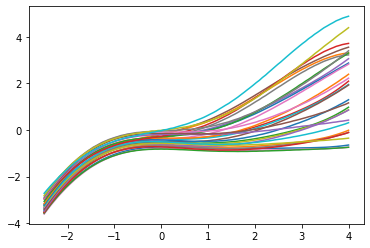

In [ ]:
for concentration in [0.2, 0.36, 0.5, 0.64, 0.8]:
  for temp in [5,6,7,8,9,10]:
    expr = Forest1.currentGeneration[5].expression
    expr = expr.subs({c:concentration})
    expr = expr.subs({T:temp})
    testF = lambdify(t,expr,"numpy")
    timeData = np.linspace(-2.5,4,100)
    result =  testF(timeData)
    result
    plt.plot(timeData, result)
plt.show()